In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy


sc.set_figure_params(figsize=(4, 4))

In [4]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# MALE

### Read in dataset

In [5]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [6]:
adata = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

In [7]:
adata = adata[[i in 'male' for i in adata.obs.sex]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(33017, 23713)

In [8]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_males_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['lineage'].to_dict()
adata.obs['lineage_previous'] = adata.obs_names.map(cell_annot).astype('category')

Trying to set attribute `.obs` of view, copying.


In [12]:
# Import predictions from SVM
meta = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/SVM_males_probs.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

dfnames = meta.columns.tolist()

for clname in dfnames:
    cell_annot = meta[clname].to_dict()
    adata.obs[clname] = adata.obs_names.map(cell_annot)

adata.obs.head()

n_genes            sample stage   sex  \
HCA_Mou_10827181_AAACCTGAGTAGATGT     4478  HCA_Mou_10827181  12.5  male   
HCA_Mou_10827181_AAACCTGAGTCATGCT     3796  HCA_Mou_10827181  12.5  male   
HCA_Mou_10827181_AAACCTGCAAGAGTCG     5995  HCA_Mou_10827181  12.5  male   
HCA_Mou_10827181_AAACCTGCAGACACTT     4818  HCA_Mou_10827181  12.5  male   
HCA_Mou_10827181_AAACCTGCATGCCTTC     4590  HCA_Mou_10827181  12.5  male   

                                  location  percent_mito  n_counts batch  \
HCA_Mou_10827181_AAACCTGAGTAGATGT    gonad      0.021894   14268.0     0   
HCA_Mou_10827181_AAACCTGAGTCATGCT    gonad      0.022123   10237.0     0   
HCA_Mou_10827181_AAACCTGCAAGAGTCG    gonad      0.014868   28210.0     0   
HCA_Mou_10827181_AAACCTGCAGACACTT    gonad      0.017001   15585.0     0   
HCA_Mou_10827181_AAACCTGCATGCCTTC    gonad      0.013677   14742.0     0   

                                    S_score  G2M_score  ... prob_Immune  \
HCA_Mou_10827181_AAACCTGAGTAGATGT  0.244737  -1.118329  ...    0.009266   
HCA_Mou_10827181_AAACCTGAGTCATGCT -0.584211  -0.958706  ...    0.007032   
HCA_Mou_10827181_AAACCTGCAAGAGTCG  0.171053  -2.909845  ...    0.002932   
HCA_Mou_10827181_AAACCTGCAGACACTT  1.352632   1.623118  ...    0.002506   
HCA_Mou_10827181_AAACCTGCATGCCTTC -0.960526  -1.341705  ...    0.004588   

                                   prob_Mesenchymal_GATA2  \
HCA_Mou_10827181_AAACCTGAGTAGATGT                0.445024   
HCA_Mou_10827181_AAACCTGAGTCATGCT                0.007648   
HCA_Mou_10827181_AAACCTGCAAGAGTCG                0.094187   
HCA_Mou_10827181_AAACCTGCAGACACTT                0.103002   
HCA_Mou_10827181_AAACCTGCATGCCTTC                0.568200   

                                   prob_Mesenchymal_LHX9  prob_Neural  \
HCA_Mou_10827181_AAACCTGAGTAGATGT               0.242845     0.002221   
HCA_Mou_10827181_AAACCTGAGTCATGCT               0.908979     0.000840   
HCA_Mou_10827181_AAACCTGCAAGAGTCG               0.004978     0.000353   
HCA_Mou_10827181_AAACCTGCAGACACTT               0.842056     0.000127   
HCA_Mou_10827181_AAACCTGCATGCCTTC               0.147958     0.000374   

                                    prob_PV  prob_SMCs  prob_Supporting  \
HCA_Mou_10827181_AAACCTGAGTAGATGT  0.027860        NaN         0.023722   
HCA_Mou_10827181_AAACCTGAGTCATGCT  0.015944        NaN         0.032939   
HCA_Mou_10827181_AAACCTGCAAGAGTCG  0.005522        NaN         0.018205   
HCA_Mou_10827181_AAACCTGCAGACACTT  0.024597        NaN         0.005325   
HCA_Mou_10827181_AAACCTGCATGCCTTC  0.015545        NaN         0.221344   

                                  prob_preGranulosa prob_FetalLeydig  \
HCA_Mou_10827181_AAACCTGAGTAGATGT               NaN         0.007659   
HCA_Mou_10827181_AAACCTGAGTCATGCT               NaN         0.014293   
HCA_Mou_10827181_AAACCTGCAAGAGTCG               NaN         0.006329   
HCA_Mou_10827181_AAACCTGCAGACACTT               NaN         0.005213   
HCA_Mou_10827181_AAACCTGCATGCCTTC               NaN         0.014687   

                                  prob_Sertoli  
HCA_Mou_10827181_AAACCTGAGTAGATGT     0.008549  
HCA_Mou_10827181_AAACCTGAGTCATGCT     0.001889  
HCA_Mou_10827181_AAACCTGCAAGAGTCG     0.001069  
HCA_Mou_10827181_AAACCTGCAGACACTT     0.001244  
HCA_Mou_10827181_AAACCTGCATGCCTTC     0.001816  

[5 rows x 38 columns]

In [8]:
sc.pp.filter_genes(adata, min_counts=3)

### Remove cc genes

In [9]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 23713


### Identify HVGs

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="stage"
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.


In [11]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize - optional

In [12]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Load latent space scVI

In [13]:
X_scVI = pd.read_csv(path_to_gonads+'/mouse-gonads_XscVI_latent_male.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Visualization and Clustering

In [14]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

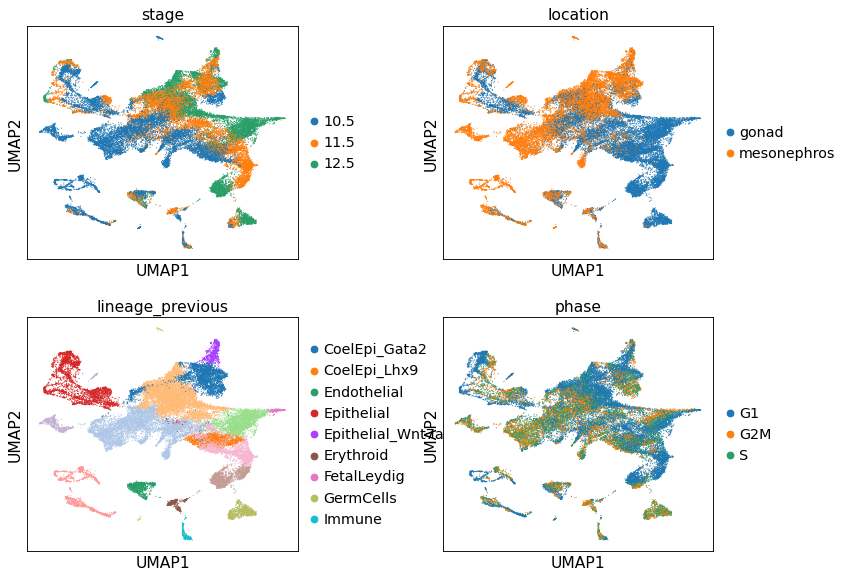

In [15]:
sc.pl.umap(
    adata,
    color=[ "stage", 'location',  'lineage_previous', 'phase'], 
    frameon=True, ncols = 2, wspace = 0.4
)

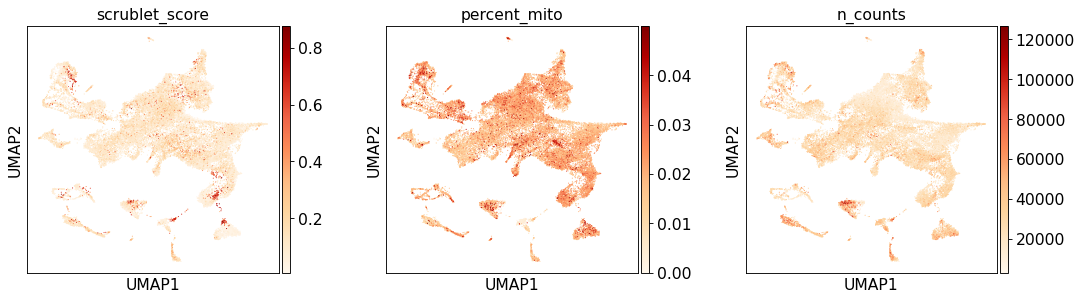

In [16]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

### Clustering

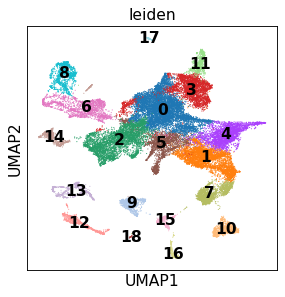

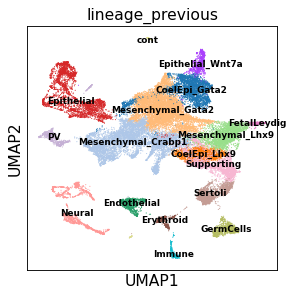

In [17]:
sc.tl.leiden(adata, resolution=0.4)
sc.pl.umap(
    adata,
    color=['leiden'], color_map = "OrRd",legend_loc='on data',
    frameon=True,  wspace = 0.3
)
sc.pl.umap(
    adata,
    color=["lineage_previous"], ncols = 2,
    legend_loc='on data', legend_fontsize=8
)

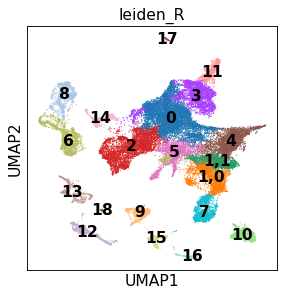

In [25]:
# separate supp from coel epi
sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['1']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

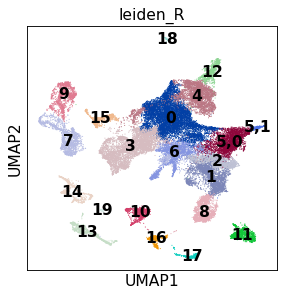

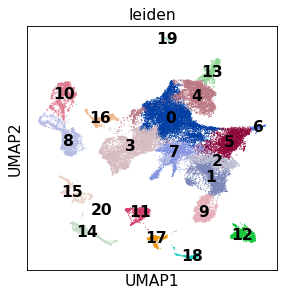

In [27]:
# release fetal leydig
sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['5']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
adata.obs['leiden'] = adata.obs['leiden_R']
sc.pl.umap(adata, color='leiden',legend_loc='on data')

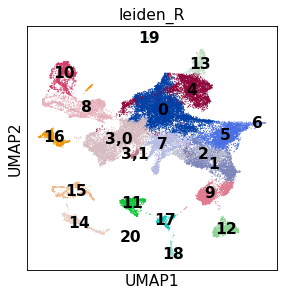

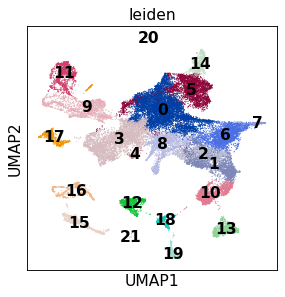

In [55]:
# release PV
sc.tl.leiden(adata, resolution=0.075, restrict_to=('leiden', ['3']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
adata.obs['leiden'] = adata.obs['leiden_R']
sc.pl.umap(adata, color='leiden',legend_loc='on data')

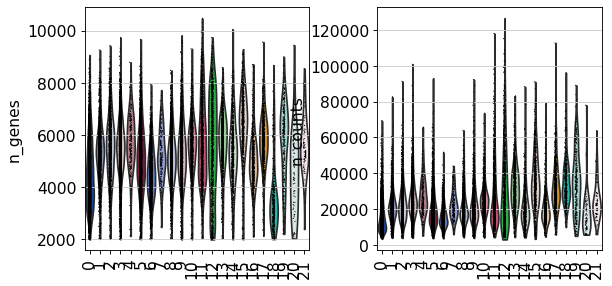

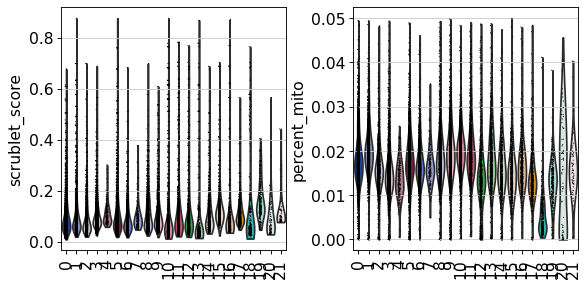

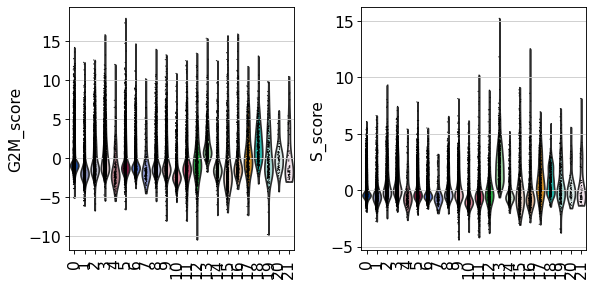

In [56]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['G2M_score', 'S_score'], groupby='leiden_R', rotation=90)

## Markers

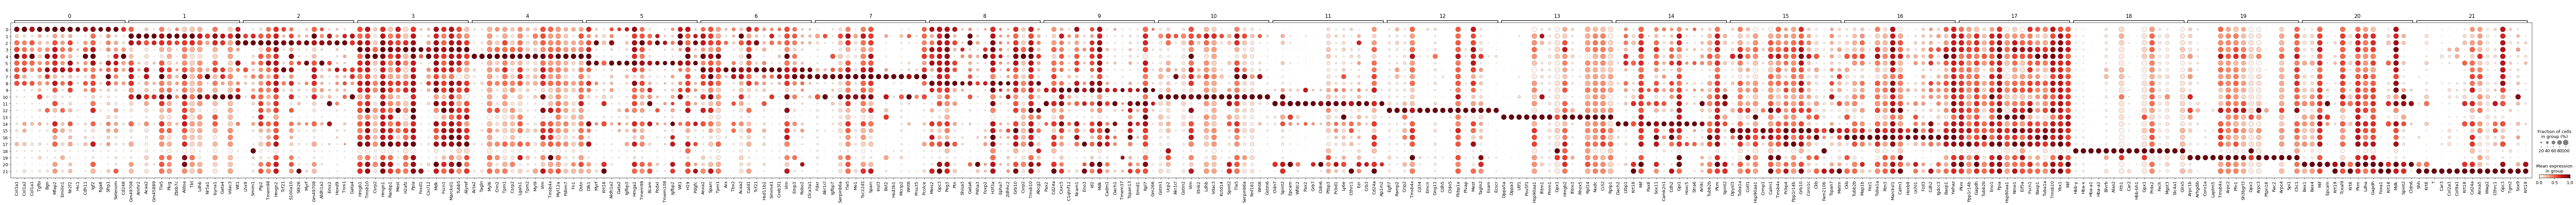

In [57]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

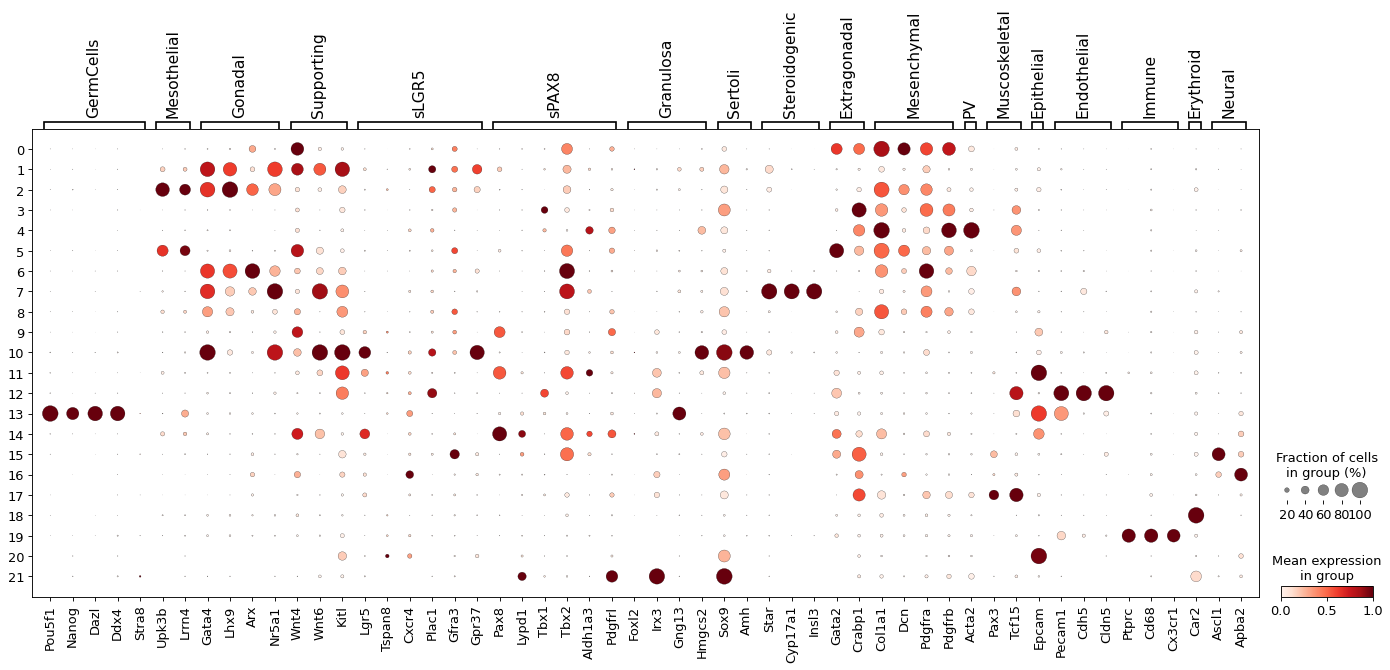

In [58]:
marker_genes = {'GermCells' : ['Pou5f1', 'Nanog', 'Dazl', 'Ddx4', 'Stra8'], 
'Mesothelial' : ['Upk3b', 'Lrrn4'], 
'Gonadal' : ["Gata4", "Lhx9", 'Arx', 'Nr5a1'], 
'Supporting' : ['Wnt4',  'Wnt6',  'Kitl'], 
 'sLGR5' : ['Lgr5', 'Tspan8', 'Cxcr4', 'Plac1', "Gfra3",'Gpr37'],
 'sPAX8' : ['Pax8', 'Lypd1', 'Tbx1', 'Tbx2', 'Aldh1a3', 'Pdgfrl'], 
'Granulosa' : [ 'Foxl2', 'Irx3', 'Gng13','Hmgcs2'], 
 'Sertoli':['Sox9', 'Amh'],
 'Steroidogenic' : ['Star', 'Cyp17a1', 'Insl3'],
 'Extragonadal' : ['Gata2',   'Crabp1'], 
 'Mesenchymal' : ['Col1a1', 'Dcn', 'Pdgfra', 'Pdgfrb'],
 'PV':['Acta2'], 
 'Muscoskeletal':['Pax3', 'Tcf15'],
 'Epithelial' : ['Epcam'], 
 'Endothelial' : ['Pecam1', 'Cdh5', 'Cldn5'],
 'Immune' : ['Ptprc', 'Cd68', 'Cx3cr1'], 
 'Erythroid' : ['Car2'], 
 'Neural' : ['Ascl1', 'Apba2']
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

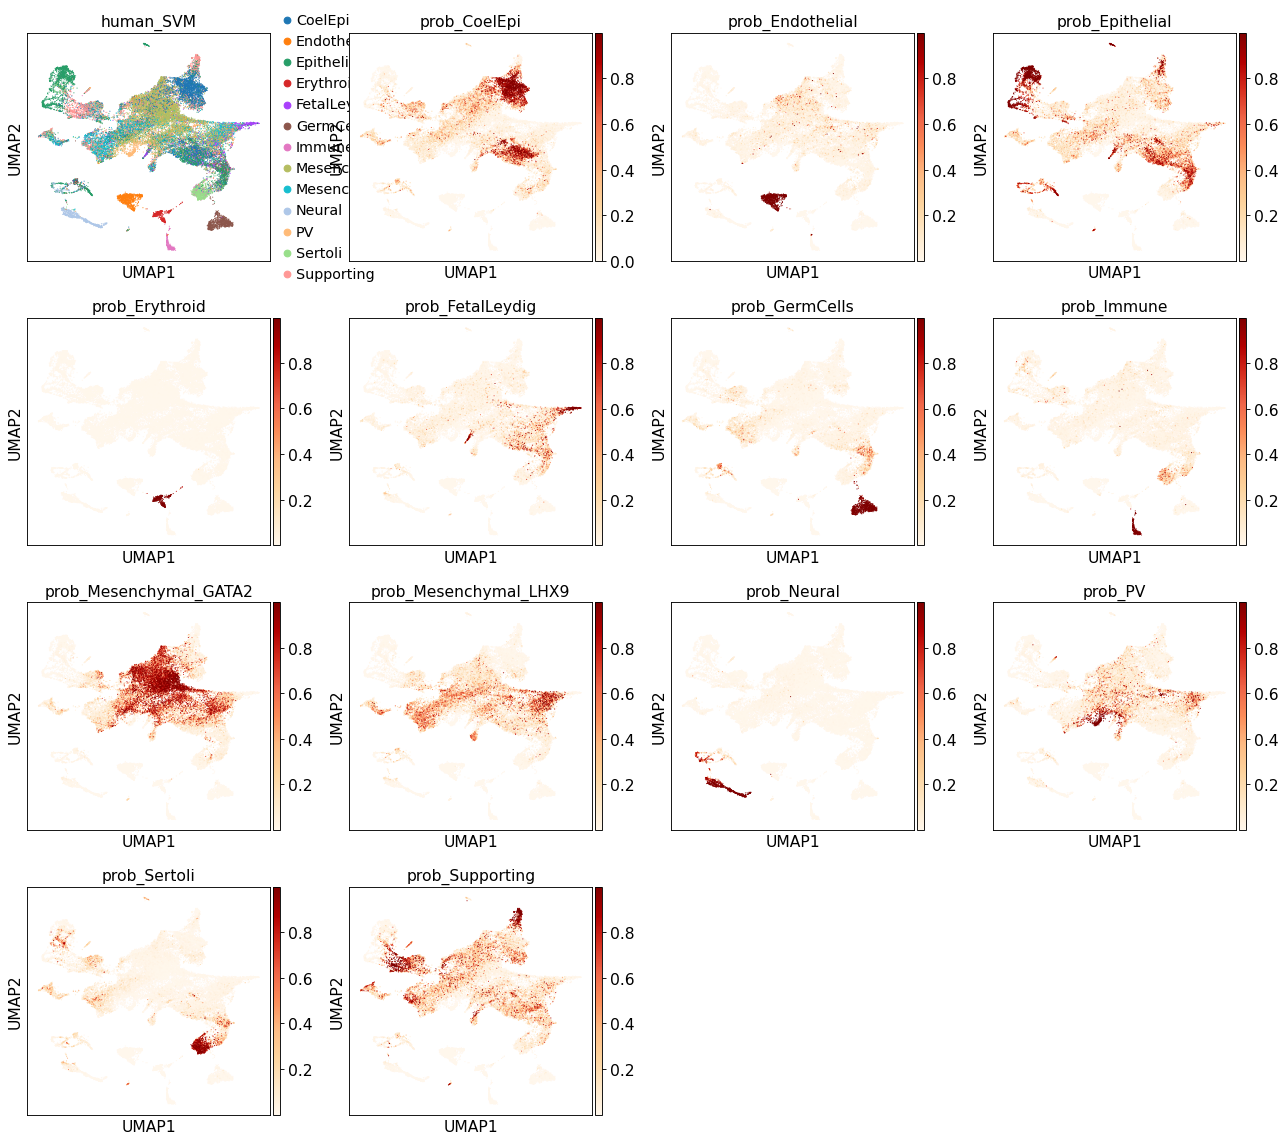

In [59]:
# Plot predictions from SVM
meta = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/SVM_males_probs.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

dfnames = meta.columns.tolist()

sc.pl.umap(
    adata,
    color=dfnames, color_map = "OrRd")


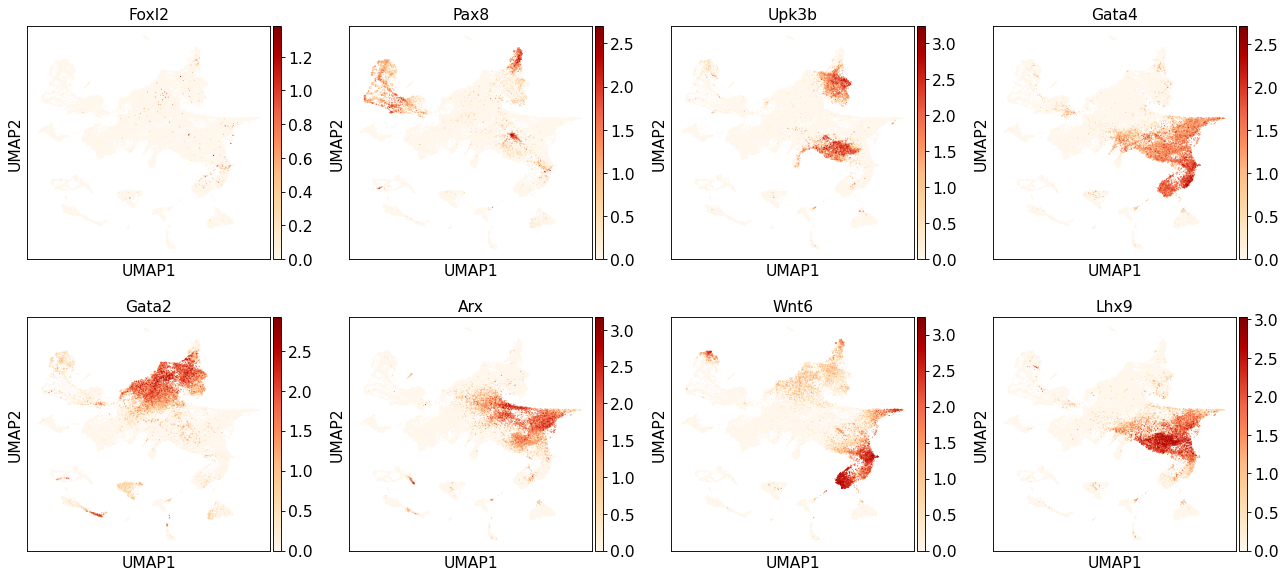

In [69]:
sc.pl.umap(
    adata,
    color=['Foxl2', 'Pax8', 'Upk3b', 'Gata4','Gata2', 'Arx', 'Wnt6', 'Lhx9'], color_map = "OrRd")

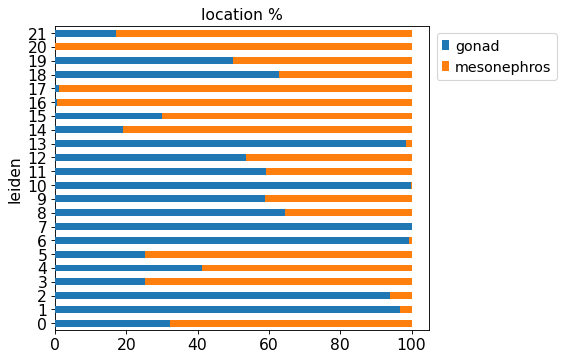

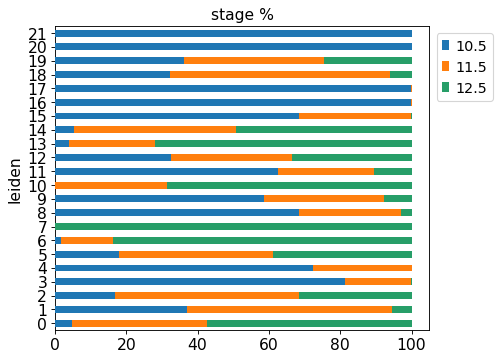

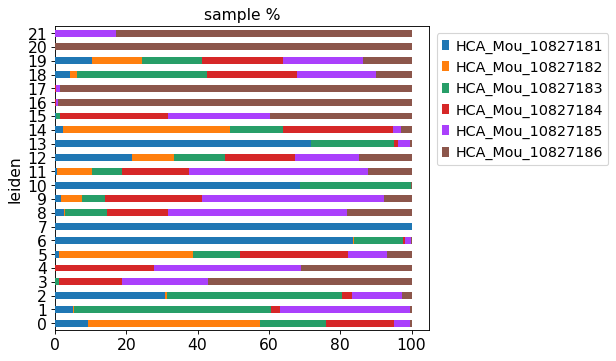

In [61]:
Barplot('location', adata, var='leiden', height=5)
Barplot('stage', adata, var='leiden', height=5)
Barplot('sample', adata, var='leiden', height=5)

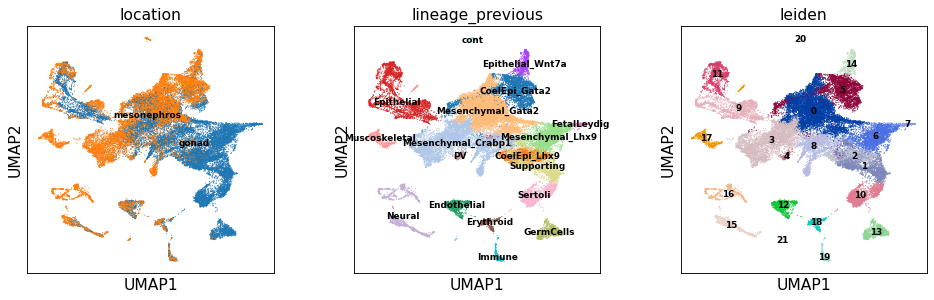

In [62]:
sc.pl.umap(
    adata,
    color=['location', "lineage_previous", 'leiden'], ncols = 3,
    legend_loc='on data', legend_fontsize=8
)

... storing 'lineage' as categorical


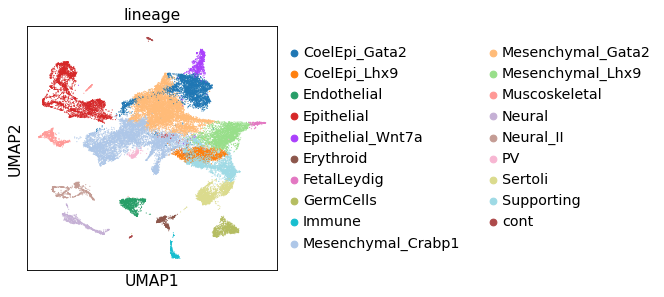

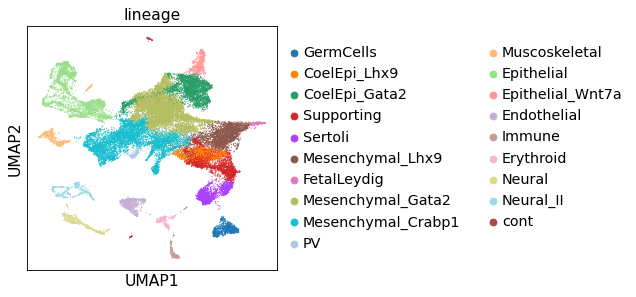

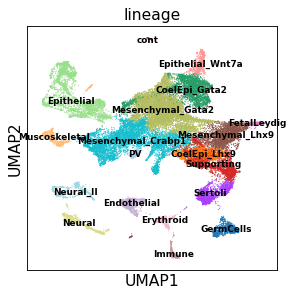

In [63]:
adata.obs['lineage'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['lineage'] == '0', 'lineage'] = 'Mesenchymal_Gata2'
adata.obs.at[adata.obs['lineage'] == '1', 'lineage'] = 'Supporting'
adata.obs.at[adata.obs['lineage'] == '2', 'lineage'] = 'CoelEpi_Lhx9'
adata.obs.at[adata.obs['lineage'] == '3', 'lineage'] = 'Mesenchymal_Crabp1'
adata.obs.at[adata.obs['lineage'] == '4', 'lineage'] = 'PV'
adata.obs.at[adata.obs['lineage'] == '5', 'lineage'] = 'CoelEpi_Gata2'
adata.obs.at[adata.obs['lineage'] == '6', 'lineage'] = 'Mesenchymal_Lhx9'
adata.obs.at[adata.obs['lineage'] == '7', 'lineage'] = 'FetalLeydig'
adata.obs.at[adata.obs['lineage'] == '8', 'lineage'] = 'Mesenchymal_Crabp1'
adata.obs.at[adata.obs['lineage'] == '9', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '10', 'lineage'] = 'Sertoli'
adata.obs.at[adata.obs['lineage'] == '11', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '12', 'lineage'] = 'Endothelial'
adata.obs.at[adata.obs['lineage'] == '13', 'lineage'] = 'GermCells'
adata.obs.at[adata.obs['lineage'] == '14', 'lineage'] = 'Epithelial_Wnt7a'
adata.obs.at[adata.obs['lineage'] == '15', 'lineage'] = 'Neural'
adata.obs.at[adata.obs['lineage'] == '16', 'lineage'] = 'Neural_II'
adata.obs.at[adata.obs['lineage'] == '17', 'lineage'] = 'Muscoskeletal'
adata.obs.at[adata.obs['lineage'] == '18', 'lineage'] = 'Erythroid'
adata.obs.at[adata.obs['lineage'] == '19', 'lineage'] = 'Immune'
adata.obs.at[adata.obs['lineage'] == '20', 'lineage'] = 'cont'
adata.obs.at[adata.obs['lineage'] == '21', 'lineage'] = 'cont'
set(adata.obs['lineage'])
sc.pl.umap(adata, color=['lineage'])
adata.obs['lineage'].cat.reorder_categories(['GermCells', 'CoelEpi_Lhx9', 'CoelEpi_Gata2', 'Supporting', 'Sertoli',
                                             'Mesenchymal_Lhx9', 'FetalLeydig',
                                              'Mesenchymal_Gata2', 'Mesenchymal_Crabp1',  'PV', 'Muscoskeletal',
                                              'Epithelial','Epithelial_Wnt7a',  
                                               'Endothelial', 'Immune',   'Erythroid', 'Neural', 'Neural_II',
                                             'cont'], inplace=True)


sc.pl.umap(adata, color=['lineage'])
sc.pl.umap(adata, color=['lineage'], ncols = 2, legend_loc='on data', legend_fontsize=8)

# Save visualization

In [64]:
adata.write(path_to_gonads+'/mouse-gonads_male.h5ad')
adata.obs.to_csv(path_to_gonads+'/mouse-gonads_males_annotated.csv')

## Examine visualization

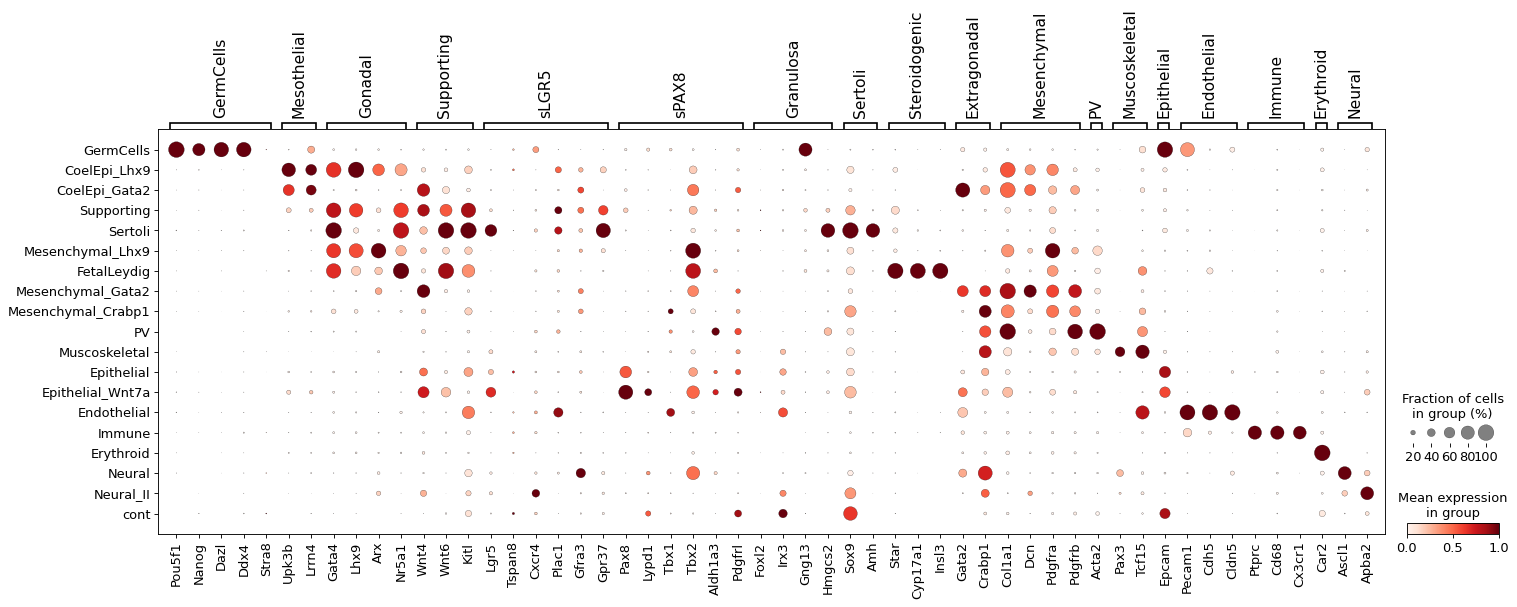

In [65]:
sc.pl.dotplot(adata, marker_genes, groupby='lineage', use_raw=False, standard_scale = 'var')

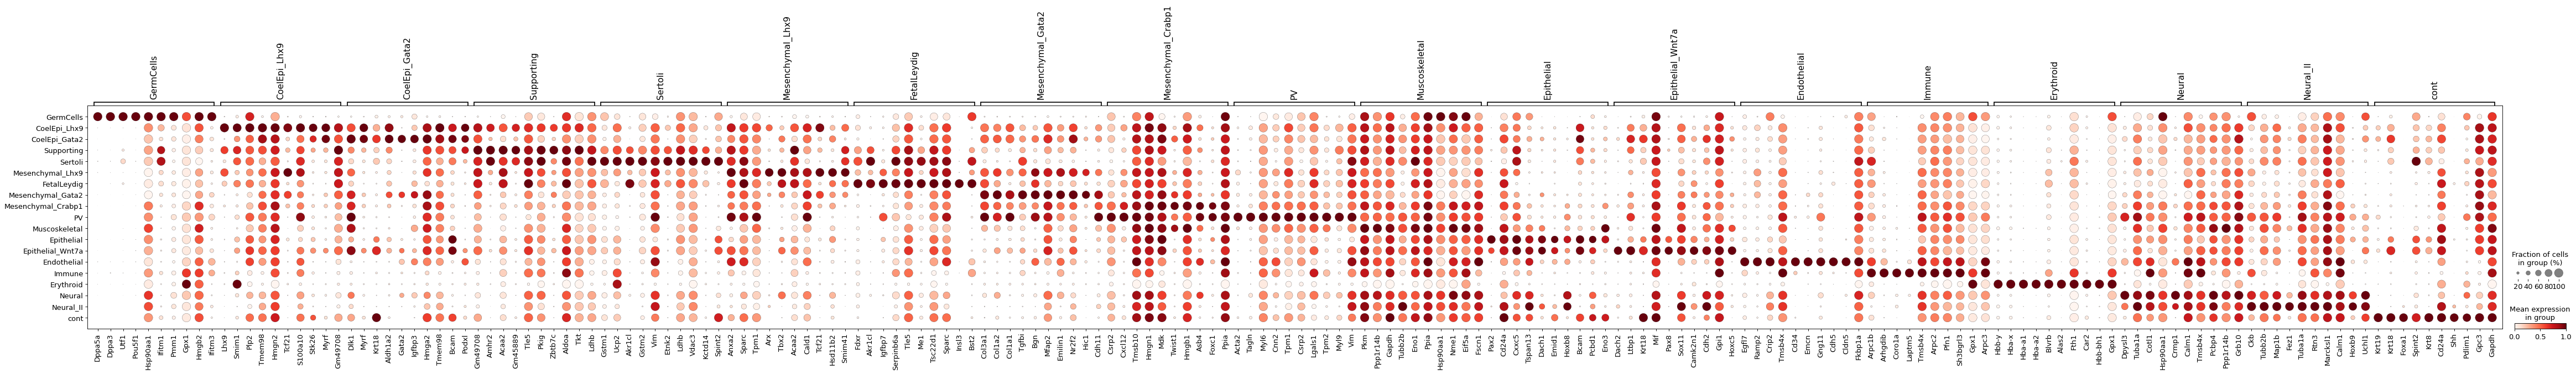

In [66]:
# bdata.obs['lineage'] = adata.obs['lineage']
sc.tl.rank_genes_groups(adata, groupby='lineage', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, dendrogram=False, use_raw = False, standard_scale = 'var')

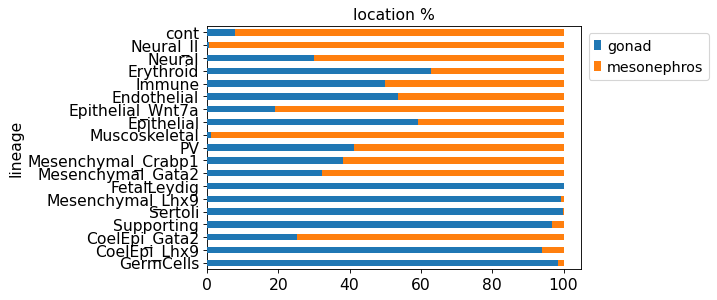

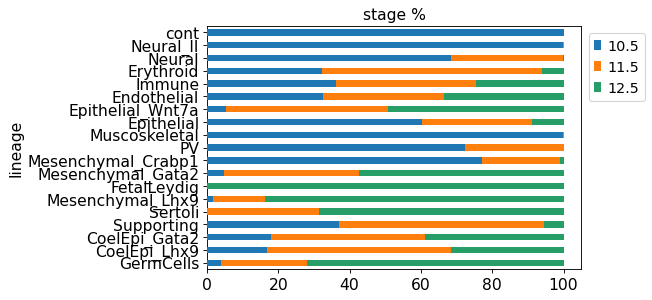

In [67]:
Barplot('location', adata, var='lineage', height=4)
Barplot('stage', adata, var='lineage', height=4)